# NEURAL NETWORKS AND DEEP LEARNING, part 2

Contents of this excercise:
   
1. [Dataset - recap](#1)    
1. [2-Layer Neural Network](#2)
   1. [Size of layers and initializing parameters - weights and bias](#3)
   1. [Feed forward (forward propagation)](#4)
   1. [Loss function and Cost function](#5)
   1. [Backward propagation](#6)
   1. [Update parameters](#7)
   1. [Prediction with learnt parameters weight and bias](#8)
   1. [Create Model](#9)
1. [L-Layer Neural Network - DEEP LEARNING](#10)
    1. [Implementing with Keras library](#11)
    1. [TODO No. 1: Implement model using Keras library](#11)
    1. [TODO No. 2: Play with hyperparamethers](#11)
    1. [TODO No. 3: Multi class classification with NN](#12)


In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt


<a id="1"></a> <br>
## 1. Dataset - recap
* We will use sign language digits data set again.
* There are 2062 sign language digits images in this dataset, representing numbers from 0 to 9 in the sign language.
* In our dataset, sign zero is between indexes 204 and 408, so number of samples is 205.
* Also sign one is between indexes 822 and 1027, with number of samples 206. Therefore, we will use 205 samples from each class (label).
* X is image array (zero and one signs) and Y is label array (0 and 1).

(2062, 64, 64)


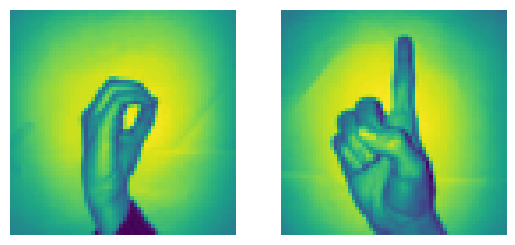

In [55]:
# load data set
x_l = np.load('./input/Sign-language-digits-dataset/X.npy')
Y_l = np.load('./input/Sign-language-digits-dataset/Y.npy')
print(x_l.shape)
plt.subplot(1, 2, 1)
plt.imshow(x_l[300])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900])
plt.axis('off')
plt.show()

In [56]:
# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 0 to 204 is zero sign and from 205 to 410 is one sign 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


In [57]:
# Then create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
print(number_of_train)
print(number_of_test)
print(X_train.shape)
print(Y_train.shape)

348
62
(348, 64, 64)
(348, 1)


In [58]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (348, 4096)
X test flatten (62, 4096)


In [59]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


<a id="2"></a> <br>
## 2. 2-Layer Neural Network

* **What is neural network**: It is basically repeating logistic regression at least 2 times
    * Logistic regression -> input and output layers
    * Neural networks -> at least one hidden layer between input and output layers
* **What is deep, in order to say "deep" how many layers do I need to have**: 
    * "Deep" is a relative term, referring of course to the "depth" of a network
    * 30 years ago, two or three hidden layers were possible using the specialized hardware of the day
    * A couple years ago 20 layers were considered pretty deep 
    * Nowadays -> hundreds or even thousands
* **Why is it called hidden**: Because hidden layer does not interfere with inputs (training set) directly
* A network with an input, one hidden and an output layer is considered as 2 layer neural network, because while computing layer number input layer is ignored
* Lets see 2-layer neural network: 
<a href="http://ibb.co/eF315x"><img src="http://preview.ibb.co/dajVyH/9.jpg" alt="9" border="0"></a>
* We will study this image step by step:
    * As you can see there is one hidden layer between input and output layers. And this hidden layer has 3 nodes (perceptrons). Number of nodes is a hyperparameter (like learning rate). 
    * Input and output layers, similar to the logistic regression, use **Sigmoid** activation function.
    * On the other hand **Tanh** activation function is better than sigmoid for hidden units bacause mean of its output is closer to zero so it centers the data better for the next layer. Also tanh activation function increase non-linearity that helps our model to learn better.
    * Logistic regression vs. Neural networks.
        * In logistic regression: input => output
        * In 2-layer neural network: input => hidden layer => output.
   

In [60]:
# Definition of sigmoid
def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

<a id="3"></a> <br>
### 2.1 Size of layers and initializing parameters -  weights and bias
* x_train has 348 samples - $x^{(348)}$:
$$z^{[1] (348)} =  W^{[1]} x^{(348)} + b^{[1] (348)}$$ 
$$a^{[1] (348)} = \tanh(z^{[1] (348)})$$
$$z^{[2] (348)} = W^{[2]} a^{[1] (348)} + b^{[2] (348)}$$
$$\hat{y}^{(348)} = a^{[2] (348)} = \sigma(z^{ [2] (348)})$$

* In the previous part of this exercise (logistic regression), we initialized weights as 0.01 and bias as 0 values. 
* Now, we will initialize weights randomly, because we would like to avoid that each perceptron in the first hidden layer performs exactly the same computation. Also, initial weights values should be small, because this can help in speeding up the optimization process. 
* Bias can be zero initially.

In [61]:
# intialize parameters and layer sizes
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(3,x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((3,1)),
                  "weight2": np.random.randn(y_train.shape[0],3) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

<a id="4"></a> <br>
### 2.2 Feed Forward (forward propagation)
* Forward propagation is almost the same as for the logistic regression in the prevous part of this exercise.
* The only difference is the usage of tanh function and processing of two layers.
* Conveniently, numpy has tanh function.

In [62]:

def forward_propagation_NN(x_train, parameters):

    Z1 = np.dot(parameters["weight1"],x_train) +parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache


<a id="5"></a> <br>
### 2.3 Loss function and Cost function
* Loss and cost functions are same as before.
* Cross entropy function
<a href="https://imgbb.com/"><img src="https://image.ibb.co/nyR9LU/as.jpg" alt="as" border="0"></a><br />

In [63]:
# Compute cost
# def compute_cost_NN(A2, Y, parameters):
#     logprobs = np.multiply(np.log(A2),Y)
#     cost = -np.sum(logprobs)/Y.shape[1]
#     return cost



def compute_cost_NN(A2, Y, parameters):
    m = Y.shape[1]
    cost = -(1/m) * np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2))
    cost = np.squeeze(cost)
    return cost

<a id="6"></a> <br>
### 2.4 Back propagation
* The logic is same as in the previuos part.

In [64]:
# Backward Propagation
def backward_propagation_NN(parameters, cache, X, Y):
    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads


<a id="7"></a> <br>
### 2.5 Update Parameters 
* Updating parameters is also the same as for the logistic regression.

In [65]:
# update parameters
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

<a id="8"></a> <br>
### 2.6 Prediction with learnt parameters - weight and bias
* Prediction method, similar to logistic regression.

In [66]:
# prediction
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

<a id="9"></a> <br>
### 2.7 Create model
* Lets put all together

Cost after iteration 0: 0.701054
Cost after iteration 100: 0.694106
Cost after iteration 200: 0.693248
Cost after iteration 300: 0.693124
Cost after iteration 400: 0.693101
Cost after iteration 500: 0.693092
Cost after iteration 600: 0.693087
Cost after iteration 700: 0.693083
Cost after iteration 800: 0.693079
Cost after iteration 900: 0.693075
Cost after iteration 1000: 0.693070
Cost after iteration 1100: 0.693065
Cost after iteration 1200: 0.693058
Cost after iteration 1300: 0.693047
Cost after iteration 1400: 0.693028
Cost after iteration 1500: 0.692979
Cost after iteration 1600: 0.692683
Cost after iteration 1700: 0.683467
Cost after iteration 1800: 0.660836
Cost after iteration 1900: 0.611317
Cost after iteration 2000: 0.536003
Cost after iteration 2100: 0.455566
Cost after iteration 2200: 0.384897
Cost after iteration 2300: 0.358766
Cost after iteration 2400: 0.407056


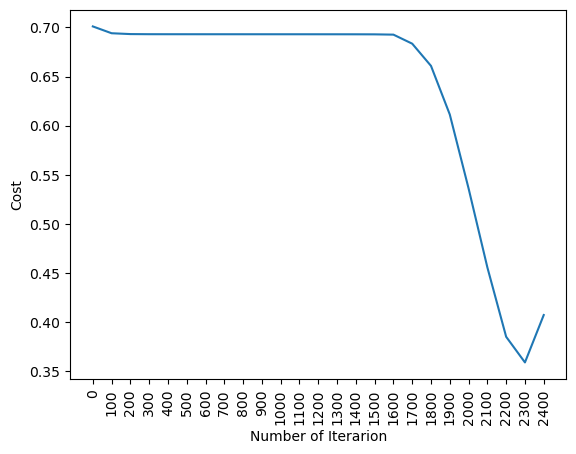

train accuracy: 97.1264367816092 %
test accuracy: 95.16129032258064 %


In [67]:
# 2 - Layer neural network
def two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)

    for i in range(0, num_iterations):
         # forward propagation
        A2, cache = forward_propagation_NN(x_train,parameters)
        # compute cost
        cost = compute_cost_NN(A2, y_train, parameters)
        # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
        # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 100 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters

parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations=2500)

<a id="10"></a> <br>
## 3. L Layer Neural Network - DEEP LEARNING
* **What happens if number of hidden layer increase:** 
    * First layerls can detect simple features (straight lines).
    * Later (following) layers can detect more and more complex features (shapes). 
    * For example, lets look at our sign one:
<a href="http://ibb.co/dNgDJH"><img src="http://preview.ibb.co/mpD4Qx/10.jpg" alt="10" border="0"></a>

* Lets create our model
    * There are some hyperparameters we need to choose like learning rate, number of iterations, number of hidden layer, number of hidden units, type of activation functions. 
    * These hyperparameters can be chosen intiutively.
    * Or you can take a look in the literature/google for recommendations. 
    * In any case, you need to test diferent hyperparameters to find the best one.
    * In the example in this exercise our model will have 2 hidden layers, with 8 and 4 perceptrones, respectively.  
    * As an activation function we will use relu (first hidden layer), relu (second hidden layer) and sigmoid (output layer).
    * Number of iterations will be 100.
* This task is very similar to the previous part, however as we already learned the logic behind, we can ease our job and use keras library for deeper neural networks.

    
    

In [68]:
# reshaping
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

<a id="11"></a> <br>
### 3.1 Implementing with keras library
Lets look at some parameters of the Keras library:
* units: number of perceptrons per layer
* kernel_initializer: to initialize weights
* activation: activation function (relu, sigmoid, tanh)
* input_dim: input dimension (number of pixels in our images: 4096)
* optimizer: we will use Adam optimizer (google a little bit about this)
    * Adam is one of the most effective optimization algorithms for training neural networks.
    * Some advantages of Adam: relatively low memory requirements and usually works well even with only a little tuning of hyperparameters
* loss: cost function is the same as in the previous example (the name of our cost function is cross-entropy).
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small$$
* metrics: accuracy.
* cross_val_score: we will use cross validation.
* epochs: number of training iterations.

<a id="12"></a> <br>
### TODO No. 1: Implement model using Keras library
* Two hidden layers (8 and 4 perceptrons, 'relu' activation), output layer ('sigmoid' activation) 
* Use cross validation
* Present accuracy

In [69]:

# Define the model
def create_model(input_dim):
    model = Sequential([
        Dense(8, input_dim=input_dim, activation='relu'),  # First hidden layer
        Dense(4, activation='relu'),  # Second hidden layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Flatten the input data
X_flatten = X.reshape(X.shape[0], -1)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
accuracies = []

for train_index, test_index in kf.split(X_flatten):
    X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Create and train the model
    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)  # Train for 20 epochs
    
    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Predict and threshold at 0.5
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold accuracy: {accuracy:.2f}")

# Report average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average accuracy across folds: {average_accuracy:.2f}")
average_accuracy = np.mean(accuracies)
print(f"Average accuracy across folds: {average_accuracy:.2f}")


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Fold accuracy: 0.45


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Fold accuracy: 0.45


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Fold accuracy: 0.46


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold accuracy: 0.48


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold accuracy: 0.46
Average accuracy across folds: 0.46
Average accuracy across folds: 0.46


<a id="12"></a> <br>
### TODO No. 2: Play with hyperparamethers
* Try with different number of layers
* ... different number of perceptrons per layer
* ... different activation functions
* What is the best combination of parameters in your tests?


In [73]:
# Your input is extected here...

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the model
def create_model(input_dim):
    model = Sequential([
        Dense(8, input_dim=input_dim, activation='relu'),  # First hidden layer
        Dense(4, activation='relu'),  # Second hidden layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Flatten the input data
X_flatten = X.reshape(X.shape[0], -1)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
accuracies = []

for train_index, test_index in kf.split(X_flatten):
    X_train, X_test = X_flatten[train_index], X_flatten[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Create and train the model
    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)  # Train for 20 epochs
    
    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Predict and threshold at 0.5
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold accuracy: {accuracy:.2f}")

# Report average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average accuracy across folds: {average_accuracy:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold accuracy: 0.45


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Fold accuracy: 0.45


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fold accuracy: 0.46


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Fold accuracy: 0.48


C:\Users\mayow\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Fold accuracy: 0.46
Average accuracy across folds: 0.46


<a id="13"></a> <br>
### TODO No. 3: Multi class classification with NN
* Try to classify more signs with one network (e.g. signes 0, 1, 2 and 3)
* What hyperparamether combination works the best for your experiment?


In [ ]:

# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y)

# Function to create a model for multi-class classification
def create_multiclass_model(layers, perceptrons, activation, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(perceptrons[0], input_dim=X.shape[1], activation=activation))
    for layer_size in perceptrons[1:]:
        model.add(Dense(layer_size, activation=activation))
    model.add(Dense(4, activation='softmax'))  # Output layer for 4 classes
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Function to perform cross-validation with hyperparameters
def evaluate_multiclass_model(layers, perceptrons, activation, learning_rate=0.01, epochs=20, batch_size=16):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
        
        # Create and train model
        model = create_multiclass_model(layers, perceptrons, activation, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Evaluate model
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

# Experiment with different hyperparameters
results = []
configurations = [
    {"layers": 1, "perceptrons": [8], "activation": "relu"},
    {"layers": 2, "perceptrons": [8, 4], "activation": "relu"},
    {"layers": 2, "perceptrons": [16, 8], "activation": "tanh"},
    {"layers": 3, "perceptrons": [32, 16, 8], "activation": "relu"},
    {"layers": 3, "perceptrons": [16, 8, 4], "activation": "sigmoid"},
    {"layers": 2, "perceptrons": [16, 16], "activation": "elu"}
]

for config in configurations:
    accuracy = evaluate_multiclass_model(
        layers=config["layers"], 
        perceptrons=config["perceptrons"], 
        activation=config["activation"], 
        learning_rate=0.01, 
        epochs=20, 
        batch_size=16
    )
    results.append((config, accuracy))
    print(f"Config: {config}, Accuracy: {accuracy:.4f}")

# Find the best configuration
best_config = max(results, key=lambda x: x[1])
print(f"Best configuration: {best_config[0]} with accuracy: {best_config[1]:.4f}")


<a id="12"></a> <br>
## Attributions and License:

Code snippets are based on [https://www.kaggle.com/code/kanncaa1/deep-learning-tutorial-for-beginners/notebook].

This work is licensed under the [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0) open source license.
